# VADER Sentiment Analysis on Twitter Accounts of News Outlets

## Observed trends:
* CBS happened to have the most positive sentiment measure in its tweets for the range sampler
* The difference in sentiment compound score between the most positive outler (CBS) and the least positive outlet (Fox) is 6x
* There is no visible temporal trend for any media outlet 

Dependencies

In [1]:
import config
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tweepy
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sns.set()

Twitter API Keys

In [2]:
consumer_key = config.consumer_key
consumer_secret = config.consumer_secret
access_token = config.access_token
access_token_secret = config.access_token_secret

Setup Tweepy API Authentication

In [3]:
auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_token_secret)
api = tweepy.API(auth)

List of media outlets to analyze

In [4]:
news_outlets = ['BBC', 'CBS', 'CNN', 'FoxNews', 'nytimes']

Setup instance of VADER analyzer

In [5]:
analyzer = SentimentIntensityAnalyzer()

Loop over each outlet, outlet's tweets and perform sentiment analysis on each tweet

Save the per-tweet results in a pandas DataFrame

In [7]:
sentiment_df = pd.DataFrame(columns=['Source', 'Text', 'Date', 'Compound Score', 'Positive Score', 'Neutral Score', 
                                    'Negative Score'])
current_df_indx = 0
for target_user in news_outlets:
    for page in tweepy.Cursor(api.user_timeline, id=target_user).pages(5):
            for tweet in page:
                tweet_text = json.dumps(tweet._json, indent=3)
                tweet = json.loads(tweet_text)

                # Parse the tweet to identify its text and date
                tweet_text = tweet["text"]
                tweet_date = tweet["created_at"]

                # Analyze the sentiment of the tweet
                compound = analyzer.polarity_scores(tweet_text)["compound"]
                pos = analyzer.polarity_scores(tweet_text)["pos"]
                neu = analyzer.polarity_scores(tweet_text)["neu"]
                neg = analyzer.polarity_scores(tweet_text)["neg"]

                # Add the sentiment analyses to the dataframe
                sentiment_df.loc[current_df_indx, 'Source'] = target_user
                sentiment_df.loc[current_df_indx, 'Text'] = tweet_text
                sentiment_df.loc[current_df_indx, 'Date'] = tweet_date
                sentiment_df.loc[current_df_indx, 'Compound Score'] = compound
                sentiment_df.loc[current_df_indx, 'Positive Score'] = pos
                sentiment_df.loc[current_df_indx, 'Neutral Score'] = neu
                sentiment_df.loc[current_df_indx, 'Negative Score'] = neg
                                
                current_df_indx = current_df_indx + 1

In [8]:
sentiment_df.head()

,Source,Text,Date,Compound Score,Positive Score,Neutral Score,Negative Score
0,BBC,😂 Who actually watched the #Oscars? https://t....,Mon Mar 05 19:30:07 +0000 2018,0,0,1,0
1,BBC,No meat. No fish. No eggs. No milk. No cheese....,Mon Mar 05 18:38:04 +0000 2018,-0.8555,0,0.592,0.408
2,BBC,"Like father, like daughter.\n\n😂🔥 @GordonRamsa...",Mon Mar 05 17:23:22 +0000 2018,0.6124,0.263,0.737,0
3,BBC,RT @BBCFOUR: The little mouse that inspired Pi...,Mon Mar 05 17:15:34 +0000 2018,0.4472,0.211,0.789,0
4,BBC,"""I made a promise to our six-year-old lead act...",Mon Mar 05 17:00:31 +0000 2018,0.1531,0.105,0.818,0.077


Export VADER sentiment analysis of tweets to a csv file

In [9]:
sentiment_df.to_csv('news_mood.csv')

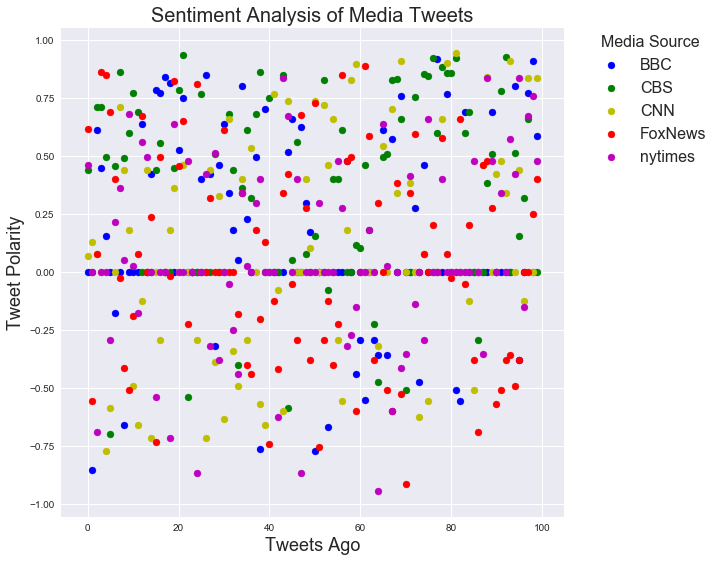

In [10]:
fig, ax = plt.subplots(figsize = (9, 9))
outlet_colors = ['b', 'g', 'y', 'r', 'm']
for outlet, color in zip(news_outlets, outlet_colors):
    tweets_order = range(len(sentiment_df[sentiment_df['Source'] == outlet]))
    ax.scatter(tweets_order, sentiment_df[sentiment_df['Source'] == outlet]['Compound Score'], label=outlet, color=color )
ax.set_xlabel('Tweets Ago', fontsize=18)
ax.set_ylabel('Tweet Polarity', fontsize=18)
ax.set_title('Sentiment Analysis of Media Tweets', fontsize=20)
legend = ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0, fontsize=16,title='Media Source')
plt.setp(legend.get_title(),fontsize=16)
plt.savefig('sentiment_media_tweets.png')
plt.show()

Overall organization sentiments for last 100 tweets

In [13]:
sentiment_gp = sentiment_df.groupby('Source')
overall_sentiments = sentiment_gp['Compound Score'].sum()/sentiment_gp['Compound Score'].count()
overall_sentiments

Source
BBC        0.153997
CBS        0.326577
CNN        0.110366
FoxNews    0.051630
nytimes    0.068555
Name: Compound Score, dtype: float64

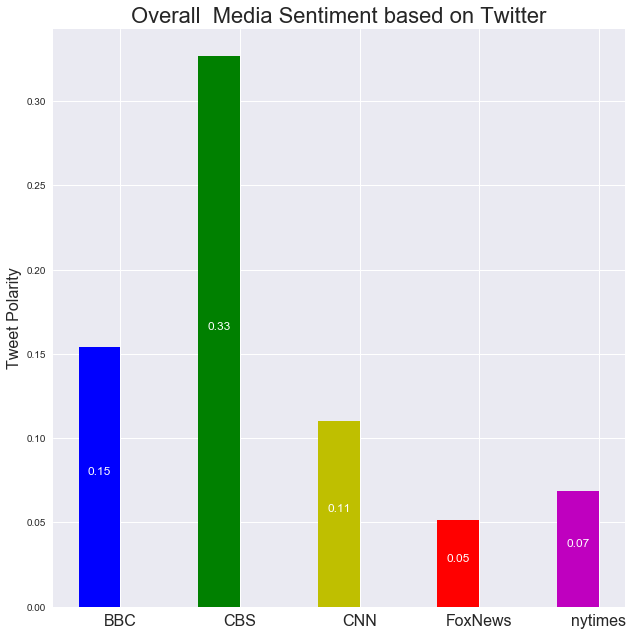

In [15]:
fig, ax = plt.subplots(figsize=(9, 9))
#set number of items to plot
ind = np.arange(len(news_outlets))
#set widht of bars to plot
width = 0.35
ax.set_title('Overall  Media Sentiment based on Twitter', fontsize=22)
ax.set_xticklabels(news_outlets, fontsize = 16)
ax.set_ylabel('Tweet Polarity', fontsize=16)
ax.set_xticks(ind + width / 2)
#plot bars
bars = ax.bar(ind, overall_sentiments, width, color=outlet_colors)
plt.legend(loc='best')
plt.tight_layout()

for bar in bars:
        #write labels at half height of bars
        label_position = .5*bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2.,
                label_position, f'{bar.get_height():0.2f}',
                ha='center', va='bottom', color='w')
plt.savefig('overall_sentiment_media.png')
plt.show()